# Experiment 1 - Model comparison with all features

The goal of this notebook is to create models that incorporate all columns. We want to see how the different models deal with this.

- The conclusion is that the RandomForestClassifier model holds up well against the neural network approach. It is, however, slightly worse than the neural network. 97.5% accuracy on the test set versus 98.0% accuracy For this reason, the in the next notebook (`n3`_text_to_vector), we will look into ways to improve the neural network by improving the word embedding of the `DescrizioneRiga` text column. 

In [4]:
import pandas as pd

# Load the Excel file
file_path = '../data/luiss_data_anonym.xlsx'
df = pd.read_excel(file_path)

In [9]:
# Delete all rows for which IvaM is missing because this is the value we want to predict
df = df[~df.IvaM.isna()]

Now we have to deal with the missing values. Either by throwing away some data or by imputing it:

In [10]:
# Delete all columns with >5% missing values and impute all the missing data:

missing_percentage = df.isnull().sum() * 100 / len(df)
columns_to_drop = missing_percentage[missing_percentage > 5].index
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.drop(columns=["DataDoc"])

# input the columns with less than 5% missing values with the mode of that column
# mode is the most common value
for column in ['B', 'D', 'Art1', 'Valore1', 'CMar', 'CTra', 'Rev', 'X']:
    df_cleaned[column] = df_cleaned[column].fillna(df_cleaned[column].mode()[0])

df_cleaned["DescrizioneRiga"] = df_cleaned["DescrizioneRiga"].fillna("")

We now check whether we removed all missing values:

In [11]:
# Check that fully inputed
nans_per_column = df_cleaned.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})

# Feature creation

In [16]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20202034\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We now have to preprocess the features:

- one-hot encode the categorical target variable
- one-hot encode the categorical features --> exploding number of categories (dummy features) --> TruncatedSVD to reduce dimensionality
- scale the numerical features (standardscaler)
- convert text-to-vector --> TF-IDF with English word lemmatizer is used

In [13]:
def preprocess_features(df, nr_reduced_features=500):
    # Split the dataset into features and target variable
    X = df.drop('IvaM', axis=1)
    y = df[['IvaM']]

    # One hot encode target variable.
    encoder = OneHotEncoder()
    encoded_y = encoder.fit_transform(y[['IvaM']])
    encoded_y = encoded_y.toarray() 

    # Preprocess independent variables.
    # First one-hot encode the categorical columns by creating dummy columns
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    categorical_features.remove("DescrizioneRiga")
    X[categorical_features] = X[categorical_features].astype(str)
    encoded_X = encoder.fit_transform(X[categorical_features])
    svd = TruncatedSVD(n_components=nr_reduced_features)
    X_reduced = svd.fit_transform(encoded_X)
    print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")
    # Numeric independent variables just have to be scaled
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X[numeric_features])
    # Text column preprocessing
    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    text_transformer = TfidfVectorizer()
    text_features = 'DescrizioneRiga'
    X[text_features] = X[text_features].apply(preprocess_text)
    vectorized_text_X = text_transformer.fit_transform(X[text_features])
    # Summarizing the text vectors using SVD
    # Reduce the data to nr_reduced_features dimensions, we use 500 as default
    svd = TruncatedSVD(n_components=nr_reduced_features)
    X_reduced_text = svd.fit_transform(vectorized_text_X)
    print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")
    print(scaled_X.shape, encoded_X.shape, X_reduced.shape, vectorized_text_X.shape, X_reduced_text.shape)

    total_X = np.hstack((scaled_X, X_reduced, X_reduced_text))
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(total_X, encoded_y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Train and evaluate NN

In [14]:
X_train, X_test, y_train, y_test = preprocess_features(df_cleaned)

Explained variance ratio: 0.8777568536346164
Explained variance ratio: 0.5158308116837842
(133966, 11) (133966, 44529) (133966, 500) (133966, 52013) (133966, 500)


We obtained data with a total of 11 + 500 + 500 = 1011 features. Furthermore, we split it into train, test

Epoch 1/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9139 - loss: 0.3622 - val_accuracy: 0.9751 - val_loss: 0.0809
Epoch 2/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9730 - loss: 0.0877 - val_accuracy: 0.9791 - val_loss: 0.0675
Epoch 3/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - accuracy: 0.9789 - loss: 0.0631 - val_accuracy: 0.9860 - val_loss: 0.0428
Epoch 4/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.9817 - loss: 0.0526 - val_accuracy: 0.9849 - val_loss: 0.0409
Epoch 5/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9833 - loss: 0.0465 - val_accuracy: 0.9888 - val_loss: 0.0321
Epoch 6/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9854 - loss: 0.0413 - val_accuracy: 0.9883 - val_loss: 0.0342
Epoch 7/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9864 - loss: 0.0396 - val_accuracy: 0.9901 - val_loss: 0.0278
Epoch 8/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9866 -

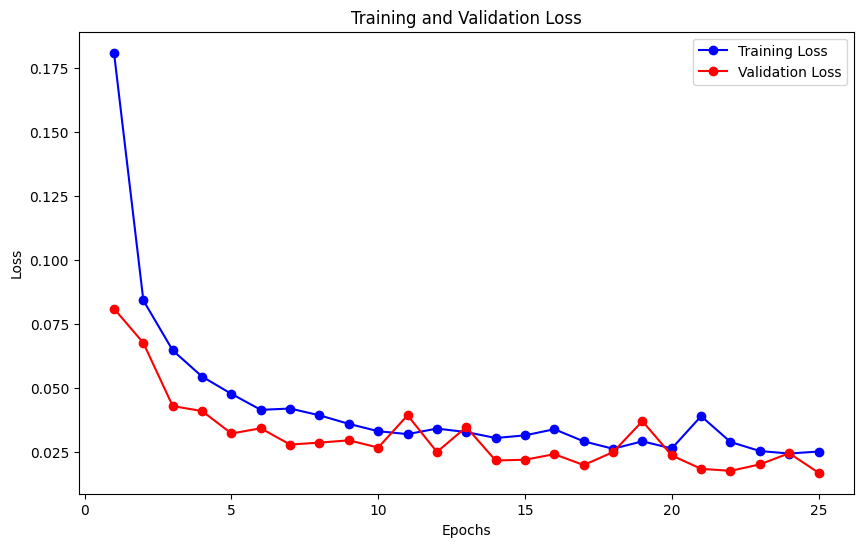

838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9803 - loss: 0.1722
Test Accuracy: 0.9802567958831787
Test Loss: 0.17508375644683838
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


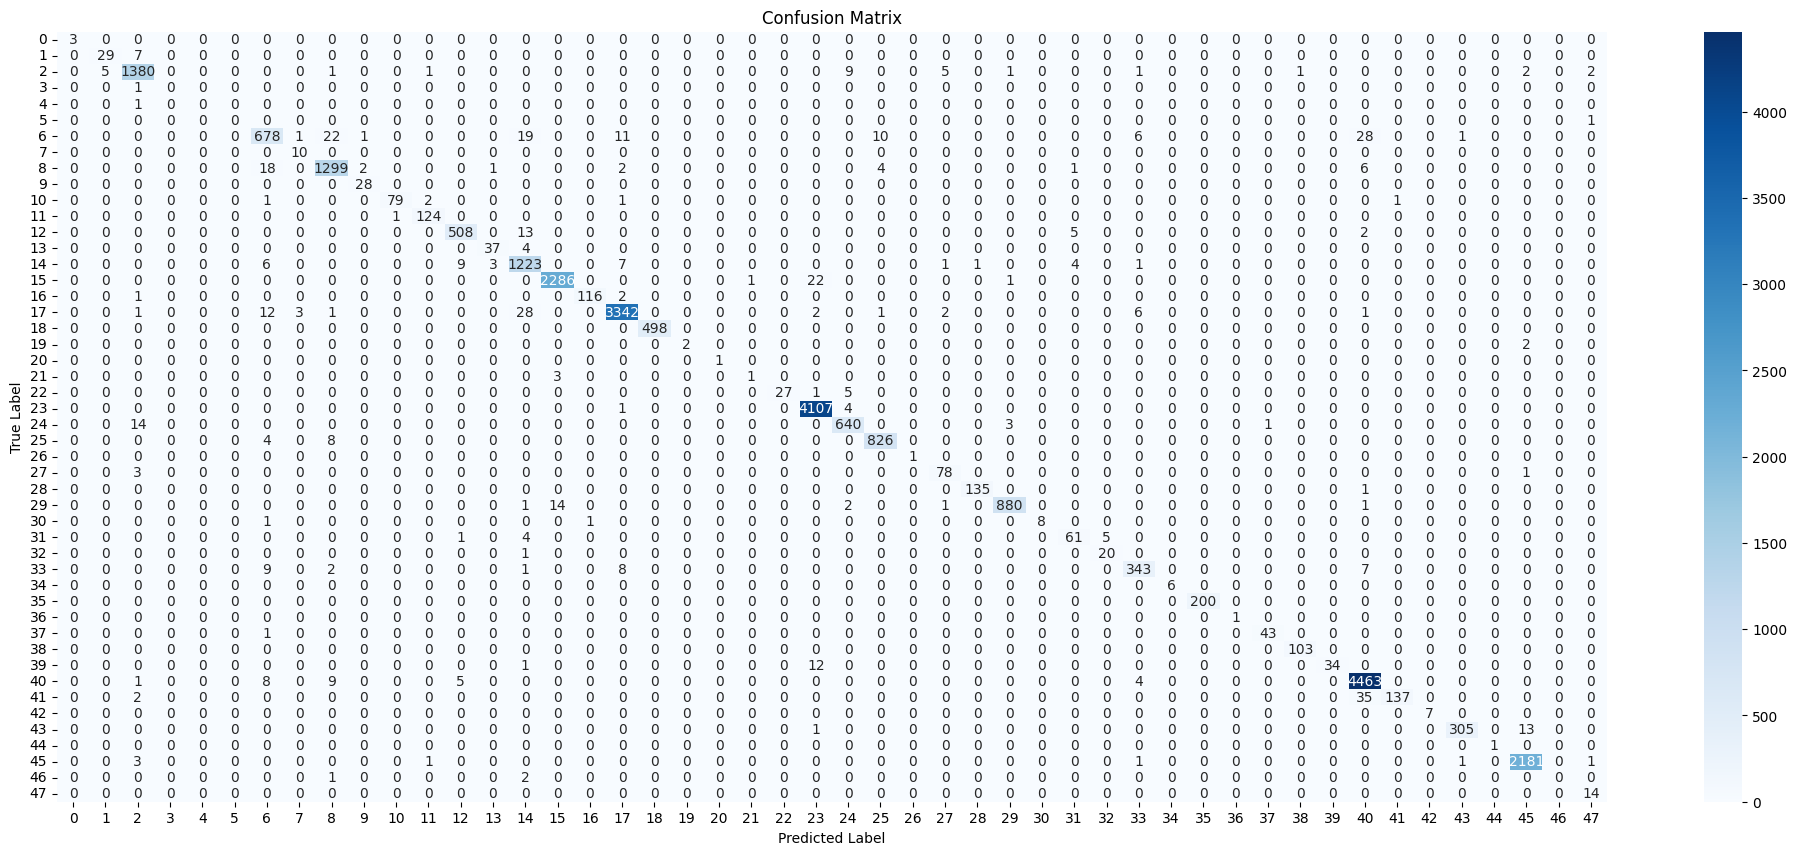

In [8]:
# split the train data into train and validation data. 
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model = keras.Sequential([
  keras.layers.Dense(units=512, activation="relu"),
  keras.layers.Dense(units=256, activation="relu"), 
  keras.layers.Dense(units=60, activation="softmax"),  # Output layer with softmax for 60 classes
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss over the epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

y_pred = model.predict(X_test)

# The predictions are one-hot-encoded so change to label
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
# Making predictions on the test set
test_predictions = model.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2, average='macro')
recall = recall_score(y_test2, y_pred2, average='macro')
f1 = f1_score(y_test2, y_pred2, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy: 0.9802567739046055
Precision: 0.8691345584670703
Recall: 0.8494466170504799
F1-Score: 0.8545025639433487


c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Train and evaluate RF

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.9s finished
c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Accuracy: 0.9750317235201911
Precision: 0.7171625348133533
Recall: 0.6643410701711502
F1-Score: 0.6863917129258891


[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.8s finished


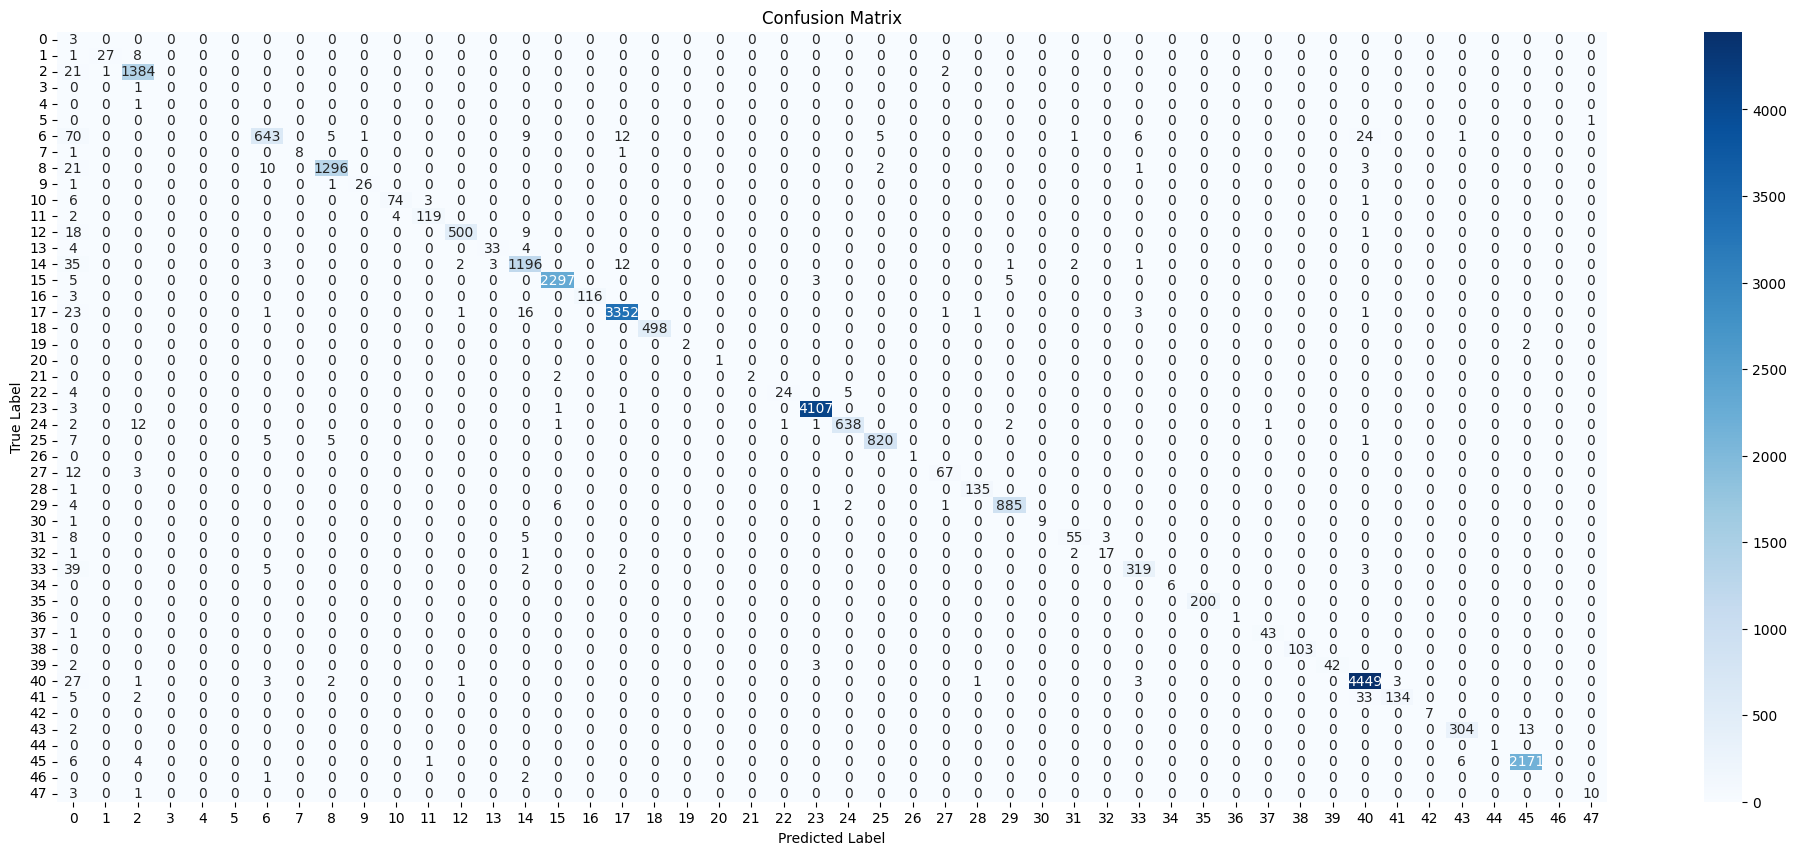

In [17]:
from sklearn.ensemble import RandomForestClassifier
import pickle

model_rf = RandomForestClassifier(verbose=2, n_estimators=100, n_jobs=-1, random_state=1)
model_rf.fit(X_train, y_train)

test_predictions = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='macro')
recall = recall_score(y_test, test_predictions, average='macro')
f1 = f1_score(y_test, test_predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

test_predictions = model_rf.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plotting the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

We print the confusion matrix, accuracy, precision, recall, and F1-score for all both models that we train here. They will be explained in the Readme.md.